# Simulation: Representation by district type under differing levels of segregation
Here, we'll run simulations of single-member districs vs. larger two-member districts under different degrees of social segrgation.

In [23]:
import numpy as np
import os
import pandas as pd
import schelling_model as schelling
import democracy

In [2]:
# Turn off pandas futurewarnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [21]:
####################
# Model parameters
####################
# Simulation metaparatmers
N_SIMULATIONS = 10

# Population 
GRID_WIDTH = 100
GRID_HEIGHT = 100
VACANCY_RATE = 0.05
POPULATION_WEIGHTS = [1, 1, 1]

# Schelling model
SATISFACTION_THRESHOLDS = np.arange(0, 0.551, 0.01)
MAX_ITERATIONS=1000

# Democracy model
DISTRICTS = [
    {"width": 10, "height": 25, "representatives": 1, "description": "single_member"}, #smaller, single-member
    {"width": 20, "height": 25, "representatives": 2, "description": "multi_member"} #larger, multi-member
]

####################
# Save Parameters
####################
# Save location
SAVE_PATH = "/Volumes/CKT-DATA/representative_democracy/data/"

# Save name
TAG = ""
if len(TAG) > 0:
    TAG = "_" + tag
SAVE_NAME = f"{int(len(POPULATION_WEIGHTS))}_types{TAG}"

In [4]:
####################
# Run simulations
####################
# Set up dataframes to collect results
results = pd.DataFrame(columns=["satisfaction_threshold", "simulation", "district_type", "segregation_mean", "diversity_mean", "representation_mean"])
district_results = pd.DataFrame(columns=["satisfaction_threshold", "simulation", "district_type", "district", "n_voters", "diversity", "segregation", "n_represented", "prop_represented"])

# Run simulations
for THRESHOLD in SATISFACTION_THRESHOLDS:
    print(f"Simulating populations with Schelling model tau = {THRESHOLD:.3f}.")

    for sim in range(N_SIMULATIONS):

        # Schelling model
        model = schelling.model.SchellingModel(
            dimensions=[GRID_WIDTH,GRID_HEIGHT],
            proportions=POPULATION_WEIGHTS,
            vacancy=VACANCY_RATE,
            satisfaction_threshold = THRESHOLD
        )
        model.evolve(
            boundary="symm",
            max_steps=MAX_ITERATIONS,
            verbose=False
        )

        # Elections
        voters = model.grid_to_long_form()
        for district_type in DISTRICTS:

            # Set up voting districts
            electorate = democracy.LegislativeDistricts(
                voters=voters,
                x_column="grid_x",
                y_column="grid_y",
                identity_column="identity"
            )
            electorate.create_districts(
                district_width=district_type["width"], 
                district_height=district_type["height"],
                verbose=False
            )

            # Conduct election, and measure satisfaction and segregation
            votes, elected = electorate.conduct_election(members_per_district=district_type["representatives"])
            representation = electorate.calculate_representation(elected=elected)
            district_segregation, overall_segregation = electorate.calculate_segregation()
            overall_diversity = sum( (district_segregation.n_voters/district_segregation.n_voters.sum()) * district_segregation.diversity )

            # Compile and add district results
            district_data = district_segregation.merge(representation.drop(columns=["n_voters"]), on="district")
            district_data["satisfaction_threshold"] = THRESHOLD
            district_data["simulation"] = sim
            district_data["district_type"] = district_type["description"]
            district_data = district_data[district_results.columns] #reorder columns
            district_results = pd.concat([district_results, district_data])

            # Add simulation-level results
            results = pd.concat([
                results,
                pd.DataFrame({
                    "satisfaction_threshold": THRESHOLD, 
                    "simulation": sim, 
                    "district_type": district_type["description"], 
                    "segregation_mean": overall_segregation,
                    "diversity_mean": overall_diversity,
                    "representation_mean": representation.prop_represented.mean()
                }, index=[0])
            ], ignore_index=True)

Simulating populations with Schelling model tau = 0.000.
Simulating populations with Schelling model tau = 0.010.
Simulating populations with Schelling model tau = 0.020.
Simulating populations with Schelling model tau = 0.030.
Simulating populations with Schelling model tau = 0.040.
Simulating populations with Schelling model tau = 0.050.
Simulating populations with Schelling model tau = 0.060.
Simulating populations with Schelling model tau = 0.070.
Simulating populations with Schelling model tau = 0.080.
Simulating populations with Schelling model tau = 0.090.
Simulating populations with Schelling model tau = 0.100.
Simulating populations with Schelling model tau = 0.110.
Simulating populations with Schelling model tau = 0.120.
Simulating populations with Schelling model tau = 0.130.
Simulating populations with Schelling model tau = 0.140.
Simulating populations with Schelling model tau = 0.150.
Simulating populations with Schelling model tau = 0.160.
Simulating populations with Sch

In [25]:
####################
# Save results
####################
if not os.path.isdir(SAVE_PATH + SAVE_NAME):
    os.mkdir(SAVE_PATH + SAVE_NAME)
results.to_csv(SAVE_PATH + SAVE_NAME + "/" + "summarized_results.csv")
district_results.to_csv(SAVE_PATH + SAVE_NAME + "/" + "district_results.csv")

In [5]:
display(results.sort_values(by=["district_type", "satisfaction_threshold"]))

,satisfaction_threshold,simulation,district_type,segregation_mean,diversity_mean,representation_mean
1,0.00,0,multi_member,0.001238,1.097252,0.684190
3,0.00,1,multi_member,0.001240,1.097250,0.684928
5,0.00,2,multi_member,0.002405,1.095970,0.693435
7,0.00,3,multi_member,0.001767,1.096671,0.684735
9,0.00,4,multi_member,0.001340,1.097140,0.685988
...,...,...,...,...,...,...
1110,0.55,5,single_member,0.422372,0.634589,0.683783
1112,0.55,6,single_member,0.399877,0.659303,0.686839
1114,0.55,7,single_member,0.473544,0.578371,0.707093
1116,0.55,8,single_member,0.407334,0.651110,0.685537


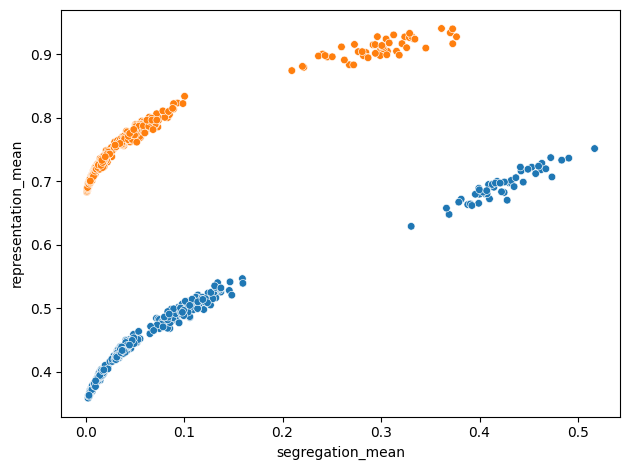

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.scatterplot(
    data=results,
    x="segregation_mean", 
    y="representation_mean",
    hue="district_type",
    s=30
)
plt.legend().remove()
plt.tight_layout()
plt.show()

In [7]:
display(district_results.sort_values(by=["district_type", "satisfaction_threshold"]))

,satisfaction_threshold,simulation,district_type,district,n_voters,diversity,segregation,n_represented,prop_represented
0,0.00,0,multi_member,1,477,1.096189,0.002206,332.0,0.696017
1,0.00,0,multi_member,2,486,1.096417,0.001999,334.0,0.687243
2,0.00,0,multi_member,3,474,1.096677,0.001762,323.0,0.681435
3,0.00,0,multi_member,4,474,1.098240,0.000339,320.0,0.675105
4,0.00,0,multi_member,5,476,1.097633,0.000892,325.0,0.682773
...,...,...,...,...,...,...,...,...,...
35,0.55,9,single_member,36,243.0,0.692461,0.369695,126.0,0.518519
36,0.55,9,single_member,37,231.0,1.054643,0.040023,110.0,0.476190
37,0.55,9,single_member,38,244.0,0.293339,0.732991,223.0,0.913934
38,0.55,9,single_member,39,242.0,0.530854,0.516796,188.0,0.776860


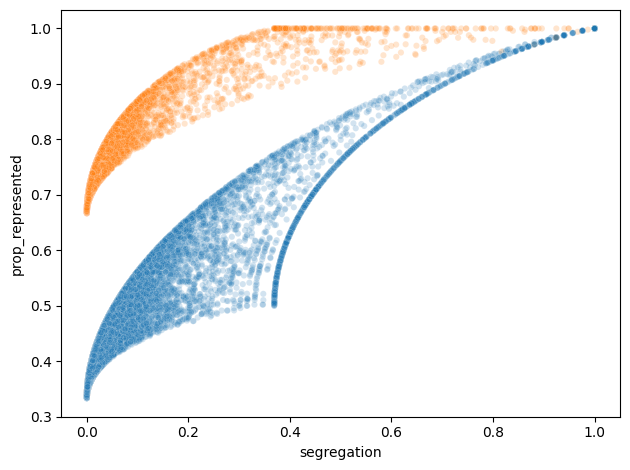

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.scatterplot(
    data=district_results,
    x="segregation", 
    y="prop_represented",
    hue="district_type",
    s=20,
    alpha=0.2
)
plt.legend().remove()
plt.tight_layout()
plt.show()